В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [21]:
%reload_ext autoreload
%autoreload 2

from process_bank_churn import preprocess_data, preprocess_new_data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
from sklearn.tree import DecisionTreeClassifier

In [9]:
train_df = pd.read_csv("train.csv")

X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(train_df)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [10]:
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "#00000000"

knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

train_preds = knn.predict_proba(X_train)[:, 1]
val_preds = knn.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9585
Validation AUROC: 0.8520


**Висновки**

train_auc непоганий. Різниця між train_auc і val_auc = 0.1. Це означає, що модель трохи перенавчилась.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [12]:
param_grid = {"n_neighbors": list(range(1, 21))}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, train_targets)

best_n_neighbors = grid_search.best_params_["n_neighbors"]
knn_best = grid_search.best_estimator_

print(f"Найкраще значення n_neighbors: {best_n_neighbors}")

train_preds_best = knn_best.predict_proba(X_train)[:, 1]
val_preds_best = knn_best.predict_proba(X_val)[:, 1]

train_auc_best = roc_auc_score(train_targets, train_preds_best)
val_auc_best = roc_auc_score(val_targets, val_preds_best)

print(f"Train AUROC (оптимальний kNN): {train_auc_best:.4f}")
print(f"Validation AUROC (оптимальний kNN): {val_auc_best:.4f}")

Найкраще значення n_neighbors: 20
Train AUROC (оптимальний kNN): 0.9352
Validation AUROC (оптимальний kNN): 0.8991


**Висновки**

Новий Train AUROC більше за попередній -- модель стала трохи краще. І різниця з Validation AUROC стала набагато менше.

Але дерево рішень виявилось все одно краще (AUROC у дерева був = 0.9147)

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [13]:
param_grid = {
    "max_depth": np.arange(1, 21, 2),
    "max_leaf_nodes": np.arange(2, 11, 1),
}

dt = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(dt, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)

start_time = time.time()
grid_search_dt.fit(X_train, train_targets)
end_time = time.time()
elapsed_time = end_time - start_time

best_params_dt = grid_search_dt.best_params_
dt_best = grid_search_dt.best_estimator_

print(f"⏳ Time GridSearchCV: {elapsed_time:.2f} seconds")
print(best_params_dt)

train_preds_dt = dt_best.predict_proba(X_train)[:, 1]
val_preds_dt = dt_best.predict_proba(X_val)[:, 1]

train_auc_dt = roc_auc_score(train_targets, train_preds_dt)
val_auc_dt = roc_auc_score(val_targets, val_preds_dt)

print(f"Train AUROC (оптимальне Decision Tree): {train_auc_dt:.4f}")
print(f"Validation AUROC (оптимальне Decision Tree): {val_auc_dt:.4f}")

⏳ Time GridSearchCV: 11.10 seconds
{'max_depth': 5, 'max_leaf_nodes': 10}
Train AUROC (оптимальне Decision Tree): 0.9073
Validation AUROC (оптимальне Decision Tree): 0.8881


**Висновки**

Попередня модель дерева все ще краща (AUROC = 0.9147) порівняно з новою (0.8881).

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [15]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [17]:
dt = DecisionTreeClassifier(random_state=42)

random_search_dt = RandomizedSearchCV(
    dt, params_dt, n_iter=40, cv=3, scoring="roc_auc", random_state=42, n_jobs=-1
)

start_time = time.time()
random_search_dt.fit(X_train, train_targets)
end_time = time.time()
elapsed_time = end_time - start_time

best_params_random = random_search_dt.best_params_
dt_random_search_best = random_search_dt.best_estimator_

print(f"⏳ Time RandomizedSearchCV: {elapsed_time:.2f} seconds")
print(best_params_random)

train_preds_random = dt_random_search_best.predict_proba(X_train)[:, 1]
val_preds_random = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auc_random = roc_auc_score(train_targets, train_preds_random)
val_auc_random = roc_auc_score(val_targets, val_preds_random)

print(f"Train AUROC (Randomized Search Decision Tree): {train_auc_random:.4f}")
print(f"Validation AUROC (Randomized Search Decision Tree): {val_auc_random:.4f}")

⏳ Time RandomizedSearchCV: 6.53 seconds
{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Train AUROC (Randomized Search Decision Tree): 0.9184
Validation AUROC (Randomized Search Decision Tree): 0.9025


**Висновки**

Randomized Search знайшов кращу модель! AUROC покращився з 0.8881 до 0.9025.

Відмінності між моделями:
Параметри моделі з GridSearch: `{'max_depth': 5, 'max_leaf_nodes': 10}`
Параметри моделі з RandomizedSearch: `{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}`


Randomized Search враховував більше параметрів, що дозволило знайти більш складну і точну модель. Randomized Search ще і працює швидше!

Судячи із лекції та дз -- GridSearch має піти у топку 😄😂


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [22]:
test_df = pd.read_csv("test.csv")

X_test = preprocess_new_data(test_df, input_cols=input_cols, encoder=encoder, scaler=scaler, scaler_numeric=True)

test_preds = dt_random_search_best.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_df["id"],
    "Exited": test_preds
})

submission.to_csv("submission.csv", index=False)

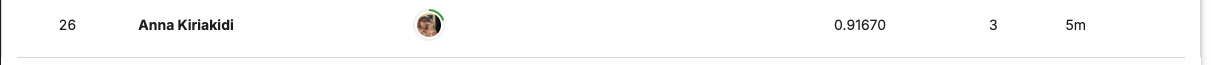